# Mise en place du réseau de neurone permettant la prédiction de SDF

In [1]:
import os
import time
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.autograd import grad
from torch.nn.functional import l1_loss
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from numpy import asarray
import tqdm
import math
import kaolin
from kaolin.ops.conversions import marching_tetrahedra
from kaolin.metrics.pointcloud import chamfer_distance
from kaolin.io.usd import export_mesh

## 1. Mise en place de l'encodeur, basé sur le réseau ResNet50

Le réseau est enrichi d'une couche en entrée permettant de lire un vecteur contenant les informations de 6 images au lieu d'une seule, ainsi que d'une couche de sortie permettant de sortir un vecteur latent de 256 caractéristiques.

In [2]:
# Define encoder
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : ", device)

Device :  cuda


## 2. Mise en place du décodeur

Le décodeur est une suite séquentielle de couches de neurones intercalées avec des couches d'activations qui permettent de prédire une valeur de SDF à partir du vecteur de taille 259 donné en entrée, correspondant au vecteur latent donné par l'encodeur concaténé à la position du point dont on veut prédire le SDF.

##### (Lancer seulement si besoin d'entraînement : )

In [3]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        #define encoder
        model_conv = models.resnet50(pretrained=True)
        model_conv.to(device)
        
        for param in model_conv.parameters():
            param.requires_grad = False
            param.to(device)
            
        num_ftrs = model_conv.fc.in_features
        model_conv.fc = nn.Linear(num_ftrs, 256)    #Add a new last fully connected layer that will output a 256-features vector
        model_conv.to(device)
        
        encoder = nn.Sequential(
        nn.Conv2d(6,3,7,2,3,bias=False),   #(in_channels=6,out_channels=3,kernel_size=7,stride=2,padding=3,bias=False)
        model_conv)
        
        self.add_module("encoder",encoder)

        self.layers = [
            nn.Linear(self.input_size, self.hidden_size),
            nn.ReLU(),
        ]
        for i in range(self.num_layers - 1):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(nn.ReLU())
        
        #Add the last layer that will output from 512 to 1 feature
        self.layers.append(nn.Linear(self.hidden_size, self.output_size))

        #Compile all the layers into a sequential model
        self.layers = nn.Sequential(*self.layers)

    #Computation performed at every call
    def forward(self, x, pt_list):
        vect_img = self.encoder(x)
        vect_img = vect_img.squeeze()
        #creer vecteur les vecteurs latents pour l liste de point
        list_vect_lat = []
        for p in pt_list:
            #print("forward info")
            vect_lat = torch.cat((vect_img,p),0)
            #print(vect_lat.shape)
            list_vect_lat.append(vect_lat)
        list_vect_lat = torch.stack(list_vect_lat).float()
        #list_vect_lat = list_vect_lat.to(float).
        #print(vect_img.type)
        #print(p.type)
        #print(vect_lat.type)
        #print(list_vect_lat.type)
        sdf_xyz_pts = torch.tanh(self.layers(list_vect_lat))
        return sdf_xyz_pts

In [4]:
#Input_size=259 (256 features + 3 positions), hidden_size=512?, output_size=1 (sdf?), num_layers=8
network = Net(259, 512, 1, 8)
network.to(device)

Net(
  (encoder): Sequential(
    (0): Conv2d(6, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, moment

## 3. Préparation des données et méthodes liées à l'entraînement

###### (Lancer si besoin d'entraîner seulement)

In [5]:
#Load data for training

# Dictionary that maps integer value to its path value (string)
int_labels = []
label_dict = {}
count = 0

#Load data for images
dataset_folder = "new_dataset"

file_list = sorted(os.listdir(dataset_folder))
for i, file in enumerate(file_list):
    file_img = sorted(os.listdir(os.path.join(dataset_folder, file, "img/03001627"))) 
    
    for idx, imgFile in enumerate(file_img):
        int_labels.append(count)
        datapath_img = os.path.join(dataset_folder, file, "img/03001627", imgFile)
        label_dict[count] = datapath_img
        count+=1

#Load data for points array and their sdf value
dataset_folder = "new_sdf_dataset"
sdf_dict = {}

file_list = sorted(os.listdir(dataset_folder))
for idx, file in enumerate(file_list):
    sdfpath_obj = os.path.join(dataset_folder, file)
    sdf_dict[file] = sdfpath_obj
    
print(sdf_dict)
print(label_dict)

{'1bcec47c5dc259ea95ca4adb70946a21': 'new_sdf_dataset/1bcec47c5dc259ea95ca4adb70946a21'}
{0: 'new_dataset/render0/img/03001627/1bcec47c5dc259ea95ca4adb70946a21', 1: 'new_dataset/render1/img/03001627/1bcec47c5dc259ea95ca4adb70946a21', 2: 'new_dataset/render2/img/03001627/1bcec47c5dc259ea95ca4adb70946a21'}


In [6]:
#Datasets preparation - 70/30
#train_dataset, val_dataset = random_split(int_labels, [int(len(int_labels)*0.7), int(len(int_labels)*0.3)])

train_dataset = TensorDataset(torch.tensor(int_labels))
#val_dataset = TensorDataset(torch.tensor(val_dataset))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=60)
#val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=40)

In [7]:
#Simple functions for displaying graphs
def my_plot(epochs, train_loss, val_loss):
    plt.plot(epochs, train_loss, val_loss)
    
def my_plot(epochs, train_loss):
    plt.plot(epochs, train_loss)

In [8]:
# Define optimizer
optimizer = torch.optim.Adam(network.parameters())

In [9]:
def laplace_regularizer_const(mesh_verts, mesh_faces):
    term = torch.zeros_like(mesh_verts)
    norm = torch.zeros_like(mesh_verts[..., 0:1])

    v0 = mesh_verts[mesh_faces[:, 0], :]
    v1 = mesh_verts[mesh_faces[:, 1], :]
    v2 = mesh_verts[mesh_faces[:, 2], :]

    term.scatter_add_(0, mesh_faces[:, 0:1].repeat(1,3), (v1 - v0) + (v2 - v0))
    term.scatter_add_(0, mesh_faces[:, 1:2].repeat(1,3), (v0 - v1) + (v2 - v1))
    term.scatter_add_(0, mesh_faces[:, 2:3].repeat(1,3), (v0 - v2) + (v1 - v2))

    two = torch.ones_like(v0) * 2.0
    norm.scatter_add_(0, mesh_faces[:, 0:1], two)
    norm.scatter_add_(0, mesh_faces[:, 1:2], two)
    norm.scatter_add_(0, mesh_faces[:, 2:3], two)

    term = term / torch.clamp(norm, min=1.0)

    return torch.mean(term**2)

def loss_f(mesh_verts, mesh_faces, points, it):
    laplacian_weight = 0.1
    print("shape loss")
    print(mesh_verts.unsqueeze(0).shape)
    print(points.shape)
    pred_points = kaolin.ops.mesh.sample_points(mesh_verts.unsqueeze(0), mesh_faces, 50000)[0][0]
    chamfer = kaolin.metrics.pointcloud.chamfer_distance(pred_points.unsqueeze(0), points).mean()
    '''
    if it > iterations//2:
        lap = laplace_regularizer_const(mesh_verts, mesh_faces)
        return chamfer + lap * laplacian_weight
    '''
    return chamfer

In [17]:
GT_mesh = mesh_points = kaolin.io.usd.import_pointclouds('./new_sdf_/GT_model.usd')[0].points.to(device)
mesh_points = GT_mesh.vertices.cuda().unsqueeze(0)
mesh_points.requires_grad = True
print(mesh_points.shape)

torch.Size([1, 11873, 3])


In [16]:
#Training loop
def training(network, num_epochs, data_train):
    train_loss = []
    grid_res = 128
    tets = torch.tensor(([np.load('samples/{}_tets_{}.npz'.format(grid_res, i))['data'] for i in range(4)]), dtype=torch.long, device='cuda').permute(1,0)

    for epoch in range(1, num_epochs+1):
        for phase in ['train']:
            if phase == 'train':
                train_epoch_loss = []
                train_epoch_acc = []

                network.train()
                data_t = next(iter(data_train))
                with tqdm.trange(len(data_t[0]), unit="subfile", mininterval=0) as bar:
                    bar.set_description(f"Epoch {epoch} / {num_epochs} - Training")
                    for i in bar:
                        # Get obj id from this path
                        subdirect = data_t[0][i]
                        path = label_dict[int(subdirect.item())]
                        #obj_id = path.split("/")[-1]
                        obj_id = path.split("\\")[3]

                        #print("Accès au dossier ", path)

                        # Load each image for this subdirectory
                        list_image = []
                        for idx, file in enumerate(os.listdir(path)):
                            if (file.endswith('.png')):
                                image = Image.open(os.path.join(path, file))
                                data = asarray(image)
                                data = data[:, :, 3]
                                list_image.append(data)

                        # Create a numpy tensor for each image
                        image_1 = torch.tensor(list_image[0], device='cuda')
                        image_2 = torch.tensor(list_image[1], device='cuda')
                        image_3 = torch.tensor(list_image[2], device='cuda')
                        image_4 = torch.tensor(list_image[3], device='cuda')
                        image_5 = torch.tensor(list_image[4], device='cuda')
                        image_6 = torch.tensor(list_image[5], device='cuda')

                        # Then concatenate these tensor in one torch.tensor
                        input_image = torch.stack((image_1, image_2, image_3, image_4, image_5, image_6), 0).float() # concatenate these 6 image so we will have a tensor with shape (1,im_height,im_width,6)
                        input_image = input_image.unsqueeze(0)
                        input_image.to(device)
                        input_image.cuda()

                        # Latent vector prediction for these 6 images (len 256)
                        #vect_image = encoder(input_image)

                        # Get pos and sdf path for this obj
                        sdf_obj_path = sdf_dict[obj_id] # maybe we can create a dictionnary (obj_id => sdf_path) insted of list in "all_sdfpath_obj"...

                        # Get the dict or correspondance list for each point and his sdf value
                        points = np.load(os.path.join(sdf_obj_path, 'pos.npy')) #each point is a array [x,y,z] which represent coordonnées
                        sdf = np.load(os.path.join(sdf_obj_path, 'sdf.npy'))

                        # Predict the sdf of each point
                        points = torch.tensor(points).to(float).to(device)
                        sdf = torch.tensor(sdf).to(float).to(device)
                        #print(points.shape)
                        #print(sdf.shape)
                        points_ds = TensorDataset(points, sdf)
                        points_dl = DataLoader(points_ds, shuffle=False, batch_size=1000)
                        count = 0
                        list_predicted_sdf = []
                        total_loss = 0
                        
                        for pts, real_sdf in points_dl:
                            predicted_sdf = network(input_image, pts)
                            
                            predicted_sdf = predicted_sdf[...,0]
                            list_predicted_sdf.append(predicted_sdf)
                            
                            #print(predicted_sdf.shape)
                            #print()
                            #print(predicted_sdf)
                            
                            # Calcul loss and accuracy
                            loss = l1_loss((100*predicted_sdf), (100*real_sdf)) # pred_sdf - real_sdf for example
                            total_loss += loss
                            
                            # Calcul gradiant
                            loss.backward()
                            count +=1
                            
                            if (count % 100 == 0):
                                print("loss ;: ", loss)
                                
                            optimizer.step()
                            optimizer.zero_grad()
                        
                        tet_verts = points.float()
                        tet_verts = tet_verts.unsqueeze(0)
                        #print(tet_verts.shape)
                        #print(tet_verts.type)
                        print()
                        
                        #sdf = torch.cat(for i in list_predicted_sdf)
                        #print(sdf.shape)
                        #print()
                        
                        list_predicted_sdf = torch.cat(list_predicted_sdf)
                        #sdf = torch.tensor(sdf, dtype=torch.float, device='cuda')
                        sdf_pred = list_predicted_sdf.cuda()
                        sdf_pred = sdf.unsqueeze(0)
                        #print(sdf.shape)
                        
                        if(epoch>1):
                            verts_list, faces_list = marching_tetrahedra(tet_verts, tets, sdf_pred, False)
                            stage = export_mesh('./pred_model_'+ str(epoch)+ str(i)+'.usd', vertices=verts_list[0], faces=faces_list[0])
                        '''
                        mesh_verts, mesh_faces = verts_list[0], faces_list[0]
                        mesh_verts.require_grad = True
                        #print(mesh_verts)
                        loss = loss_f(mesh_verts.float(), mesh_faces, mesh_points.float(), epoch)
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        print()
                        '''
                    #train_loss.append(sum(train_epoch_loss)/len(train_epoch_loss))
                    #bar.set_postfix(loss=float(sum(train_epoch_loss)/len(train_epoch_loss)), acc=f"{float(sum(train_epoch_acc)/len(train_epoch_acc))*100:.2f}%")
            
    return train_loss

In [14]:
train_loss = training(network, 3, train_dataloader)

Epoch 1 / 3 - Training:   0%|          | 0/3 [00:00<?, ?subfile/s]

loss ;:  tensor(10.8964, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7373, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 1 / 3 - Training:  33%|███▎      | 1/3 [00:35<01:10, 35.31s/subfile]


loss ;:  tensor(10.9863, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7462, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 1 / 3 - Training:  67%|██████▋   | 2/3 [01:10<00:35, 35.14s/subfile]


loss ;:  tensor(10.9975, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7454, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 1 / 3 - Training: 100%|██████████| 3/3 [01:45<00:00, 35.14s/subfile]


Epoch 2 / 3 - Training:   0%|          | 0/3 [00:00<?, ?subfile/s]

loss ;:  tensor(10.9866, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7433, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 2 / 3 - Training:  33%|███▎      | 1/3 [00:35<01:10, 35.29s/subfile]


loss ;:  tensor(11.0136, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7359, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 2 / 3 - Training:  67%|██████▋   | 2/3 [01:10<00:35, 35.25s/subfile]


loss ;:  tensor(10.9993, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7404, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 2 / 3 - Training: 100%|██████████| 3/3 [01:47<00:00, 35.88s/subfile]


Epoch 3 / 3 - Training:   0%|          | 0/3 [00:00<?, ?subfile/s]

loss ;:  tensor(10.9912, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7294, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 3 / 3 - Training:  33%|███▎      | 1/3 [00:37<01:14, 37.19s/subfile]


loss ;:  tensor(11.0216, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7011, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 3 / 3 - Training:  67%|██████▋   | 2/3 [01:14<00:37, 37.53s/subfile]


loss ;:  tensor(10.9757, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)
loss ;:  tensor(10.7410, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>)


Epoch 3 / 3 - Training: 100%|██████████| 3/3 [01:51<00:00, 37.30s/subfile]

###### (Lancer seulement si besoin de sauvegarder le modèle - Décommenter / Faire attention à ne pas écraser un modèle déjà existant : )

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

#filename = 'finalized_model.sav'
pickle.dump(decoder, open(filename, 'wb'))

## 4. Affichage des données

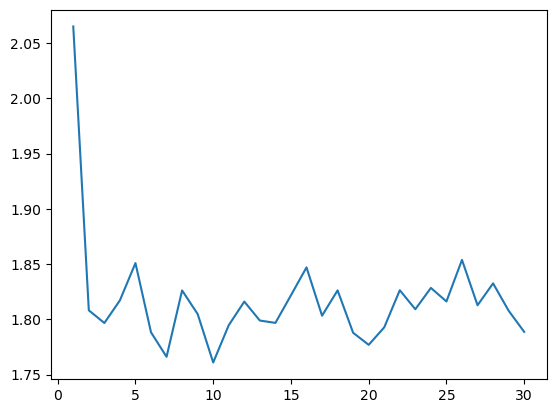

In [13]:
my_plot(np.linspace(1, 30, 30).astype(int), train_loss)

## 5. Prédiction de données à partir de l'encodeur et d'un décodeur entraîné

In [1]:
def predict(encoder, decoder, data):
    data_t = next(iter(data))
    sdf_predict = []
    with tqdm.trange(len(data_t[0]), unit="subfile", mininterval=0) as bar:
        bar.set_description(f"Prédiction du modèle")
        for i in bar:
            # Get obj id from this path
            subdirect = data_t[0][i]
            path = label_dict[int(subdirect.item())]
            obj_id = path.split("\\")[3]

            print("Accès au dossier ", path)

            # Load each image for this subdirectory
            list_image = []
            for idx, file in enumerate(os.listdir(path)):
                if (file.endswith('.png')):
                    image = Image.open(os.path.join(path, file))
                    data = asarray(image)
                    data = data[:, :, 3]
                    list_image.append(data)

            # Create a numpy tensor for each image
            image_1 = torch.tensor(list_image[0], device='cuda')
            image_2 = torch.tensor(list_image[1], device='cuda')
            image_3 = torch.tensor(list_image[2], device='cuda')
            image_4 = torch.tensor(list_image[3], device='cuda')
            image_5 = torch.tensor(list_image[4], device='cuda')
            image_6 = torch.tensor(list_image[5], device='cuda')

            # Then concatenate these tensor in one torch.tensor
            input_image = torch.stack((image_1, image_2, image_3, image_4, image_5, image_6), 0).float() # concatenate these 6 image so we will have a tensor with shape (1,im_height,im_width,6)
            input_image = input_image.unsqueeze(0)
            input_image.to(device)
            input_image.cuda()

            # Latent vector prediction for these 6 images (len 256)
            vect_image = encoder(input_image)

            # Get pos and sdf path for this obj
            sdf_obj_path = sdf_dict[obj_id] # maybe we can create a dictionnary (obj_id => sdf_path) insted of list in "all_sdfpath_obj"...

            # Get the dict or correspondance list for each point and his sdf value
            points = np.load(os.path.join(sdf_obj_path, 'pos.npy')) #each point is a array [x,y,z] which represent coordonnées
            sdf = np.load(os.path.join(sdf_obj_path, 'sdf.npy'))
            
            list_vect_latent = []
            
            # Predict the sdf of each point
            for id in range(0, len(sdf)):
                p = points[id]
                p = torch.tensor(p, device='cuda')
                p = p.unsqueeze(0)

                #print("Lecture du point ", sdf_obj_path)

                # Construct the global latent vector
                vect_latent = torch.cat((vect_image,p), 1) #concatenate -> len 259
                vect_latent = vect_latent.squeeze()
                vect_latent.to(device)
                vect_latent.cuda()

                list_vect_latent.append(vect_latent)

            stack_vect = torch.stack(list_vect_latent)
            print("Stack_vect :", stack_vect.shape)
            nb_loops = 277410//200
            predicted_sdf_list = []
            
            for i in range(0, nb_loops):
                low_threshold = 200*i
                upper_threshold = 200*(i+1)
                tmp_vect = stack_vect[low_threshold :upper_threshold, :]
                
                predicted_sdf = decoder(tmp_vect)
                
                predicted_sdf_list.append(predicted_sdf)
            
            low_threshold = 277410 - (277410%200)
            tmp_vect = stack_vect[low_threshold :277410, :]
            predicted_sdf = decoder(tmp_vect)
            predicted_sdf_list.append(predicted_sdf)
            
            all_predicted_sdf = torch.cat(predicted_sdf_list, dim=0)
            print(all_predicted_sdf.shape)
            
    return all_predicted_sdf

###### (Lancer seulement si besoin de charger un modèle du décodeur : )

In [5]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

# load the model from disk
filename = 'finalized_model.sav'
decoder = pickle.load(open(filename, 'rb'))
print(decoder)

FFNN(
  (layers): Sequential(
    (0): Linear(in_features=259, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [6]:
#Load data for predicting

# Dictionary that maps integer value to its path value (string)
int_labels = []
label_dict = {}
count = 0

#Load data for images
dataset_folder = "predict"

file_list = sorted(os.listdir(dataset_folder))
for i, file in enumerate(file_list):
    file_img = sorted(os.listdir(os.path.join(dataset_folder, file, "img/03001627"))) 
    
    for idx, imgFile in enumerate(file_img):
        int_labels.append(count)
        datapath_img = os.path.join(dataset_folder, file, "img/03001627", imgFile)
        label_dict[count] = datapath_img
        count+=1

#Load data for points array and their sdf value
dataset_folder = "sdf_predict"
sdf_dict = {}

file_list = sorted(os.listdir(dataset_folder))
for idx, file in enumerate(file_list):
    sdfpath_obj = os.path.join(dataset_folder, file)
    sdf_dict[file] = sdfpath_obj

In [7]:
#Dataset preparation
dataset = TensorDataset(torch.tensor(int_labels))
dataloader = DataLoader(dataset, shuffle=True, batch_size=1)

In [8]:
sdf = predict(encoder, decoder, dataloader)
sdf = sdf[...,0].unsqueeze(0)
print("SDF final :", sdf.shape)

sdf = sdf.numpy()
#save('/sdf_predict/sdf.npy', sdf)

Prédiction du modèle:   0%|                                                                 | 0/1 [00:00<?, ?subfile/s]

Accès au dossier  predict\render0\img/03001627\1be38f2624022098f71e06115e9c3b3e
Stack_vect : torch.Size([277410, 259])


Prédiction du modèle: 100%|█████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.41s/subfile]

277400
torch.Size([277410, 1])


## 6. Reconstruction d'un modèle 3D à partir de valeurs de SDF prédites

###### (Lancer seulement si besoin de charger un fichier de valeur SDF - changer le nom du fichier à charger : )

In [24]:
sdf = np.load('sdf_dataset_old/1bcec47c5dc259ea95ca4adb70946a21/sdf.npy')
print(sdf[:20])

sdf = torch.tensor(sdf, dtype=torch.float, device='cuda')
sdf = sdf.unsqueeze(0)

print(sdf.shape)

[0.7324503  0.72935754 0.71682054 0.73338735 0.7207073  0.7202037
 0.71025324 0.7186455  0.71252084 0.70285153 0.7030958  0.7040121
 0.6896396  0.69207627 0.6857143  0.67638373 0.6762767  0.67758965
 0.4920022  0.48254684]
torch.Size([1, 277410])


In [25]:
#Using MarchingTetrahedra to get the mesh
grid_res = 128
tet_verts = torch.tensor(np.load('samples/{}_verts.npz'.format(grid_res))['data'], dtype=torch.float, device='cuda')
tets = torch.tensor(([np.load('samples/{}_tets_{}.npz'.format(grid_res, i))['data'] for i in range(4)]), dtype=torch.long, device='cuda').permute(1,0)

tet_verts = tet_verts.to(float)
#y_values = tet_verts[..., 1]
#z_values = tet_verts[..., 2]
#tet_verts[...,1] = z_values
#tet_verts[...,2] = y_values
tet_verts = tet_verts.unsqueeze(0)

print("Tet_verts : ", tet_verts.shape)
print("Tets : ", tets.shape)
print("SDF : ", sdf.shape)

verts_list, faces_list = marching_tetrahedra(tet_verts, tets, sdf, False)
print("Vertices mesh ", verts_list[0].shape)
print("Faces mesh : ", faces_list[0].shape)

Tet_verts :  torch.Size([1, 277410, 3])
Tets :  torch.Size([1524684, 4])
SDF :  torch.Size([1, 277410])
Vertices mesh  torch.Size([11873, 3])
Faces mesh :  torch.Size([23702, 3])


In [26]:
#Save mesh to .usd file
from kaolin.io.usd import export_mesh
stage = export_mesh('./GT_model_1.usd', vertices=verts_list[0], faces=faces_list[0])

# ANNEXES

## 1. Librairie mesh_to_sdf permettant de calculer des valeurs de sdf à partir d'un modèle et d'une liste de points

###### (Lancer seulement si besoin de calculer des valeurs réelles de sdf pour un modèle en .obj : )

In [3]:
import mesh_to_sdf
import trimesh
import pyrender
import numpy as np
import argparse, sys, os
from numpy import asarray
from numpy import save

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : ", device)

grid_res = 128
tet_verts = torch.tensor(np.load('samples/{}_verts.npz'.format(grid_res))['data'], dtype=torch.float, device=device)

mesh = trimesh.load('models/03001627/ff2223a085d32243696b74614952b2d0/model.obj')

tet_verts = tet_verts.numpy()
sdf = mesh_to_sdf.mesh_to_sdf(mesh, tet_verts, surface_point_method='scan', sign_method='normal', bounding_radius=None, scan_count=100, scan_resolution=400, sample_point_count=10000000, normal_sample_count=11)

print(len(sdf))
save('sdf_model7.npy', sdf)

Device :  cpu
277410


In [5]:
from numpy import save
grid_res = 128
points = np.load('samples/{}_verts.npz'.format(grid_res))['data']
print(points[:20])

print(points.shape)
save('pos.npy', points)

[[ 0.5     0.5     0.4844]
 [ 0.4844  0.5     0.4922]
 [ 0.4922  0.4844  0.4844]
 [ 0.5     0.4922  0.5   ]
 [ 0.4844  0.4844  0.5   ]
 [ 0.5     0.4844  0.4844]
 [ 0.4766  0.4844  0.4844]
 [ 0.4688  0.4922  0.5   ]
 [ 0.4688  0.5     0.4844]
 [ 0.4531  0.5     0.4922]
 [ 0.461   0.4844  0.4844]
 [ 0.4531  0.4844  0.5   ]
 [ 0.4453  0.4844  0.4844]
 [ 0.4375  0.4922  0.5   ]
 [ 0.4375  0.5     0.4844]
 [ 0.4219  0.5     0.4922]
 [ 0.4297  0.4844  0.4844]
 [ 0.4219  0.4844  0.5   ]
 [-0.5    -0.4766 -0.5   ]
 [-0.5    -0.4844 -0.4844]]
(277410, 3)
